In [57]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [58]:
# Device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f"Using device = {device}")

Using device = cuda


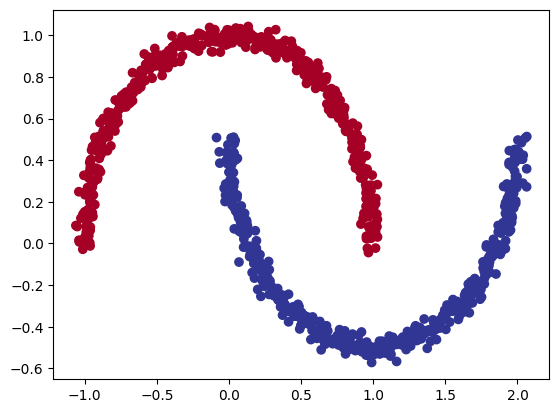

In [59]:
n_samples = 1000
X, y = make_moons(n_samples=n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [60]:
print("Before ",type(X), type(y))
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(f"After: ", type(X), type(y))

Before  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
After:  <class 'torch.Tensor'> <class 'torch.Tensor'>


In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

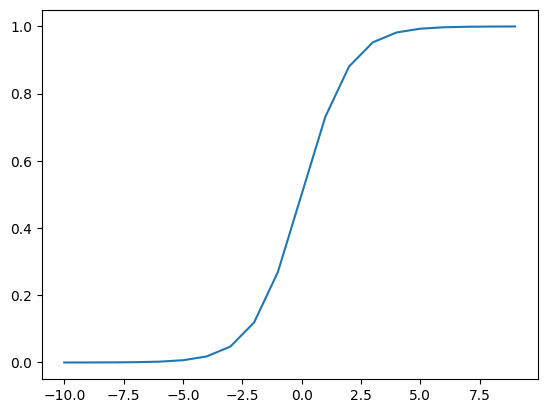

In [62]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

x = range(-10,10)
y = [sigmoid(val) for val in x]
plt.plot(x,y);

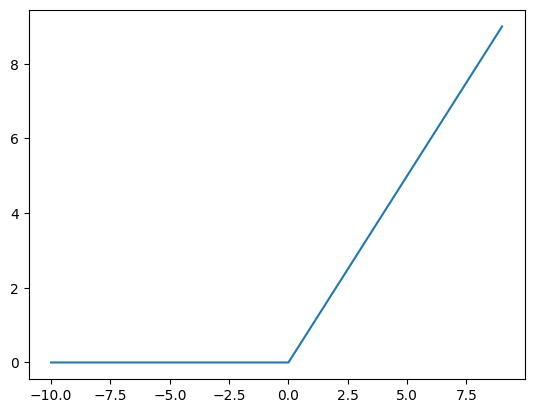

In [63]:
def RELU(x):
  if(x<=0):
    return 0
  else:
    return x

x = range(-10,10)
y = [RELU(val) for val in x]
plt.plot(x,y);

In [64]:
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)  # 2 output values per data point
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [65]:
model_0 = MoonModel()
model_0.to(device)
next(model_0.parameters()).device

device(type='cuda', index=0)

In [66]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [67]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD (
    params = model_0.parameters(), lr=0.05
)

In [68]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [69]:
epochs = 3000
torch.manual_seed(42)
trainLossList = []
testLossList = []
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

for epoch in range(epochs):
  model_0.train()

  ##1.Forward Pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))


  print(f"y_logits shape: {y_logits.shape}")
  print(f"y_train shape: {y_train.shape}")

  ##2. Compute training loss
  loss = loss_fn(y_logits, y_train)  # y_logits: model output, y_train: true labels

  ##3. Zero grad the optimizer
  optimizer.zero_grad()

  ##4. Loss --> backpropagate
  loss.backward()

  ##5. Step the optimizer
  optimizer.step()

  acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

  ###Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

  if epoch%10 == 0:
    print(f'Epoch: {epoch} | Train Loss: {loss:.4f} | Train Acc: {acc} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc}')


  trainLossList.append(loss.cpu().detach().numpy())
  testLossList.append(test_loss.cpu().detach().numpy())


Streaming output truncated to the last 5000 lines.
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
Epoch: 620 | Train Loss: 0.1869 | Train Acc: 91.5 | Test Loss: 0.1814 | Test Acc: 93.0
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
y_logits shape: torch.Size([800])
y_train shape: torch.Size([800])
Epoch: 630 | Train Loss: 0.1851 | Train Acc: 91.625 | Test

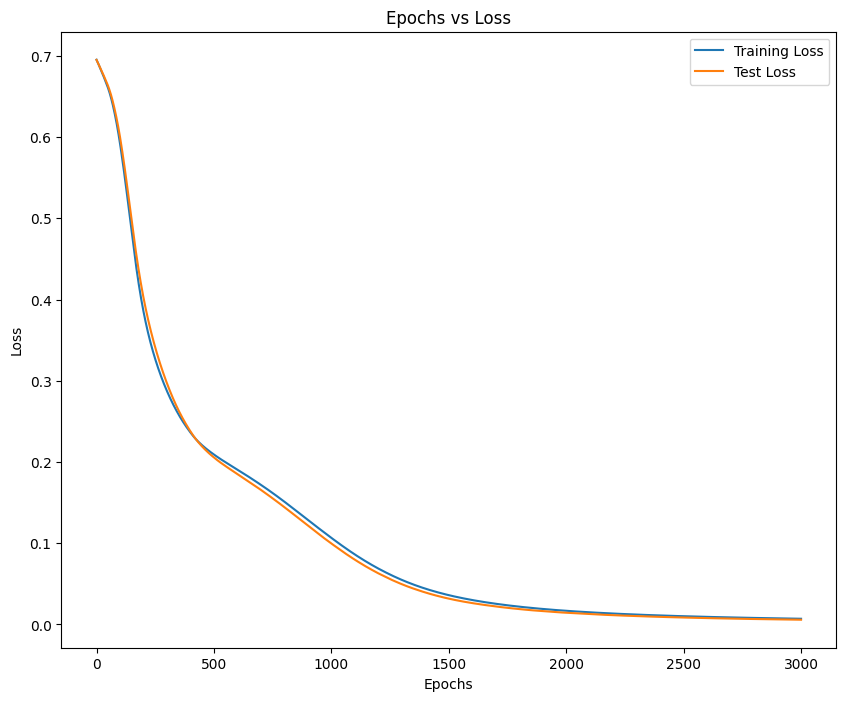

In [71]:
#Plot Loss Curve
plt.figure(figsize=(10,8))
plt.plot(range(epochs), trainLossList, label = "Training Loss")
plt.plot(range(epochs), testLossList, label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()

In [74]:
model_0.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
print(y_preds)

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.], device='cuda:0')


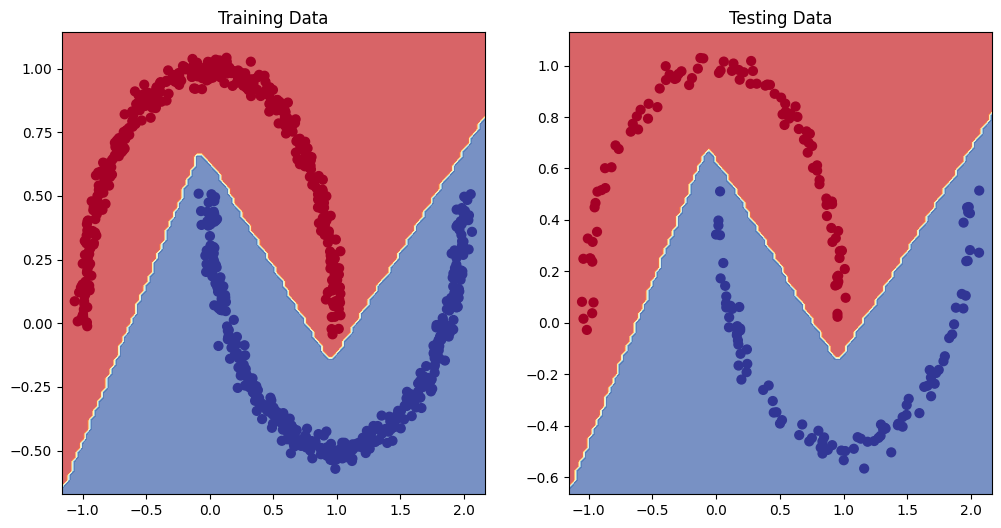

In [80]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Training Data")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Testing Data")
plot_decision_boundary(model_0, X_test, y_test)
